# Import Dependencies for Numpy, Pandas, and Matplotlib, and Dates

In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime as dt
from pandas.tools.plotting import table 

# Reflect Tables into SQLAlchemy ORM

In [2]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func
from sqlalchemy import create_engine, inspect, func

In [3]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [4]:
inspector = inspect(engine)
inspector.get_table_names()

['measurement', 'station']

In [5]:
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [6]:
columns = inspector.get_columns('station')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [7]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [8]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [9]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [10]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [11]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last data point in the database

# Perform a query to retrieve the data and precipitation scores

# Save the query results as a Pandas DataFrame and set the index to the date column

# Sort the dataframe by date

# Use Pandas Plotting with Matplotlib to plot the data


In [12]:
#Determine the last date in the Measurement Table with a recorded precipitation
latestdate=session.query(Measurement.date).order_by(Measurement.date.desc()).all()
df_latestdate=pd.DataFrame(latestdate, columns=["Date"])
lastdate=df_latestdate["Date"][0]
lastdate

'2017-08-23'

In [13]:
#Calculate the date 1 year prior to the last date in order to retrieve the last 12 months of precipitation data
query_date = dt.date(2017,8,23) - dt.timedelta(days=365)
query_date

datetime.date(2016, 8, 23)

In [19]:
#Perform a query using the date above (date for 12 months ago)
plot_prcp=session.query(Measurement.date, Measurement.prcp).filter(Measurement.date > query_date).order_by(Measurement.date).all()

In [22]:
#Converting the above query to a dataframe with column headings Date and Precipitation. 
#I also replaced all the instances of NaN values in the Precipitation column with 0.
#A preview of the dataframe is below.
df = pd.DataFrame(plot_prcp, columns=["Date", "Precipitation"])
df["Precipitation"].fillna(0, inplace=True)
df.head()

,Date,Precipitation
0,2016-08-24,0.08
1,2016-08-24,2.15
2,2016-08-24,2.28
3,2016-08-24,0.00
4,2016-08-24,1.22


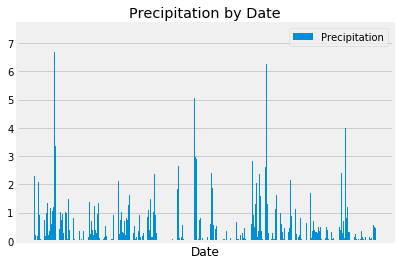

In [23]:
#Plotting the data below, The chart title is "Precipitation by Date". Date is on the X-axis and precipitation is on 
#the Y-axis. Since the dates become messy, I removed them by passing x tick labels an empty list. This helped to 
#clean up the bar chart. A chart is saved in the images folder with a file title of "precipitation".
xaxis=df["Date"]
yaxis=df["Precipitation"]
plt.bar(xaxis, yaxis, align='center', label='Precipitation')
plt.xlabel('Date')
plt.xticks([])
plt.ylim(0, max(df['Precipitation'])+1)
plt.title('Precipitation by Date')
plt.legend(loc=0)
plt.savefig("Images/precipitation.png")
plt.show()

# Exploratory Climate Analysis

In [24]:
# Use Pandas to calcualte the summary statistics for the precipitation data
stats=df.describe()
stats

,Precipitation
count,2223.000000
mean,0.159951
std,0.441220
min,0.000000
25%,0.000000
50%,0.010000
75%,0.110000
max,6.700000


C:\Users\z002y0b\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel\__main__.py:6: FutureWarning: 'pandas.tools.plotting.table' is deprecated, import 'pandas.plotting.table' instead.


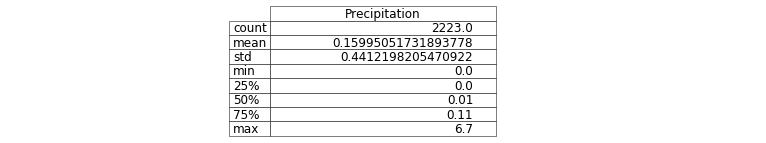

In [25]:
#Converting the stats.describe dataframe to an image in order to save it to the images folder for later viewing.
fig, ax = plt.subplots(figsize=(12, 2))
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
ax.set_frame_on(False)
tabla = table(ax, stats, loc='center', colWidths=[0.25]*len(stats.columns))
tabla.auto_set_font_size(False)
tabla.set_fontsize(12)
tabla.scale(1.2, 1.2)
plt.savefig("Images/describe.png")

In [26]:
# Design a query to show how many stations are available in this dataset?
stationcount=session.query(Station.id).count()
stationcount

9

In [27]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
activestation=session.query(Measurement.station, func.count(Measurement.station)).order_by(func.count(Measurement.station).desc()).group_by(Measurement.station).all()
df_most_active=pd.DataFrame(activestation, columns=["Station", "Station Count"])
df_most_active.head(20)


,Station,Station Count
0,USC00519281,2772
1,USC00519397,2724
2,USC00513117,2709
3,USC00519523,2669
4,USC00516128,2612
5,USC00514830,2202
6,USC00511918,1979
7,USC00517948,1372
8,USC00518838,511


In [28]:
#Saving the most active station id to a variable for use in future queries
mostactivestation=df_most_active['Station'][0]
mostactivestation

'USC00519281'

In [29]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
lowest=session.query(func.min(Measurement.tobs)).filter_by(station=mostactivestation).all()
lowest=lowest[0][0]
highest=session.query(func.max(Measurement.tobs)).filter_by(station=mostactivestation).all()
highest=highest[0][0]
average=session.query(func.avg(Measurement.tobs)).filter_by(station=mostactivestation).all()
average=average[0][0]
print(f"Lowest Temp: {lowest}")
print(f"Highest Temp: {highest}")
print(f"Average Temp: {average}")

Lowest Temp: 54.0
Highest Temp: 85.0
Average Temp: 71.66378066378067


In [30]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
tempcount=session.query(Measurement.station).order_by(func.count(Measurement.tobs).desc()).group_by(Measurement.station).first()
tempcount=tempcount[0]
tempcount

'USC00519281'

In [31]:
#Placing the precipitation values from the above query into a dataframe for use in the histrogram plot below
histogramplot=session.query(Measurement.date, Measurement.tobs).filter_by(station=tempcount).filter(Measurement.date > '2016-08-18').order_by(Measurement.date.desc()).all()
df1 = pd.DataFrame(histogramplot, columns=['Date', 'Precipitation'])
df1.head()

,Date,Precipitation
0,2017-08-18,79.0
1,2017-08-17,76.0
2,2017-08-16,76.0
3,2017-08-15,77.0
4,2017-08-14,77.0


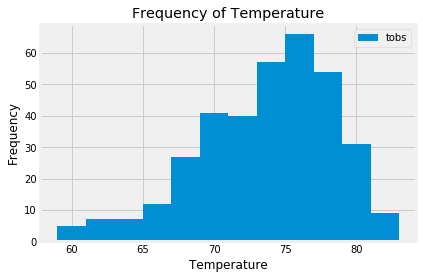

In [32]:
#Creating a histogram plot titled "Frequency of Temperature". The X-axis is the Temperature, and the Y-axis the 
#count or frequency of recorded temperatures. The file is saved in the image folder as "histogram.png"
yhist=(df1["Precipitation"])
plt.hist(yhist, bins=12)
legend = ["tobs"]
plt.xlabel("Temperature")
plt.ylabel("Frequency")
plt.title('Frequency of Temperature')
plt.legend(legend)
plt.savefig("Images/histogram.png")
plt.show()

In [33]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [34]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
tripstartdate ='2017-06-15'
tripenddate='2017-07-04'
avgtemp=(calc_temps(tripstartdate, tripenddate))
graphavg=avgtemp[0][1]
graphmin=avgtemp[0][0]
graphmax=avgtemp[0][2]

In [35]:
#Setting the x and y axis for the bar plot below
xaxis=np.arange(1)
yaxis=graphavg
yerror = graphmax-graphmin

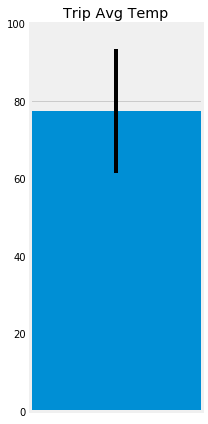

In [36]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
plt.figure(figsize=(3,6))
plt.bar(xaxis, yaxis, yerr=yerror)
plt.xticks([])
plt.xlim(-0.1,0.1)
plt.ylim(0, 100)
plt.title('Trip Avg Temp')
plt.tight_layout()
plt.savefig("Images/temperature.png")
plt.show()

In [37]:
# Calculate the rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
calc = []
sel = [Measurement.station, Station.name, Station.latitude, Station.longitude, Station.elevation, func.sum(Measurement.prcp)]
rainfallbystation = session.query(*sel).filter(Measurement.date>=tripstartdate).filter(Measurement.date>=tripenddate).filter(Measurement.station == Station.station).group_by(Measurement.station).order_by(func.sum(Measurement.prcp).desc()).all()
for record in rainfallbystation:
    (measurement_station, station_stationname, station_lat, station_long, station_elev, sum_temp) = record
    calc.append(record)
    print(
        f"{measurement_station}, {station_stationname}, {station_lat}, {station_long}, {station_elev}, {sum_temp}")


USC00516128, MANOA LYON ARBO 785.2, HI US, 21.3331, -157.8025, 152.4, 17.320000000000007
USC00519281, WAIHEE 837.5, HI US, 21.45167, -157.84888999999998, 32.9, 3.8999999999999995
USC00514830, KUALOA RANCH HEADQUARTERS 886.9, HI US, 21.5213, -157.8374, 7.0, 2.7999999999999994
USC00513117, KANEOHE 838.1, HI US, 21.4234, -157.8015, 14.6, 1.9200000000000004
USC00519523, WAIMANALO EXPERIMENTAL FARM, HI US, 21.33556, -157.71139, 19.5, 0.83
USC00519397, WAIKIKI 717.2, HI US, 21.2716, -157.8168, 3.0, 0.4000000000000001
USC00517948, PEARL CITY, HI US, 21.3934, -157.9751, 11.9, 0.01


In [38]:
#Placing the results of the above query into a dataframe. The start/end dates are added as variables in case 
#the dates change in future queries. Making the dataframe more dynamic.
stationtemp=pd.DataFrame(calc, columns=["Station Number", 
                                        "Station Name", 
                                        "Station Latitude", 
                                        "Station Longitude", 
                                        "Station Elevation", 
                                        "Total Precipitation Between Dates: " + tripstartdate + " and " + tripenddate])
stationtemp.head(10)

,Station Number,Station Name,Station Latitude,Station Longitude,Station Elevation,Total Precipitation Between Dates: 2017-06-15 and 2017-07-04
0,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4,17.32
1,USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9,3.90
2,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0,2.80
3,USC00513117,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6,1.92
4,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5,0.83
5,USC00519397,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0,0.40
6,USC00517948,"PEARL CITY, HI US",21.39340,-157.97510,11.9,0.01


## Optional Challenge Assignment

In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
